# Réseau de neurones et Causalité

Nous allons essayer d'appliquer les algorithmes de génération de cause à un réseau de neurones.

## Réseau de neurones

In [1]:
#réseau de neuronne pouvant résoudre un problème de classification sur 2 classes:
#une classe étant l'ensemble des point sur la boule unité
#l'autre étant un ensemble de point décalé par un bruit du cerce de rayon 2 centré en 0

import numpy as np
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

from main import *

def generedata(N=10000,propc1=0.5,seed = 42):
    mu, sigma = 0, 0.25
    res = []
    label = []
    np.random.seed(seed)
    while len(res)<N:
        if np.random.rand() < propc1: #classe 1 boule unité
            label.append(1)
            tmp = 2*np.random.rand(2) - 1
            while np.linalg.norm(tmp,ord =2) > 1:
                tmp = 2 * np.random.rand(2) - 1
            res.append(tmp)
        else: #classe 0 cercle bruité
            label.append(0)
            r =  min(3,np.random.normal(2, sigma))
            theta = 2*np.pi * np.random.rand()
            res.append(np.array([r*np.cos(theta),r*np.sin(theta)]))
    return np.array(res),np.array(label)

def scoring(Y_pred,Y_test):
    n = Y_pred.size
    cpt = 0
    for i in range(n):
        if Y_pred[i] == Y_test[i]:
            cpt += 1
    return 100*cpt/n




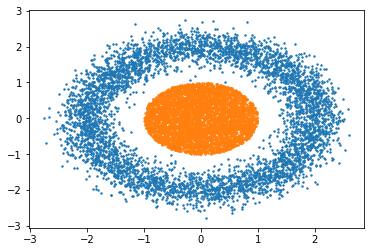

In [2]:
s = 438042
X_train,Y_train = generedata(seed = s)
plt.scatter(X_train[np.where(Y_train ==0)][:,0],X_train[np.where(Y_train ==0)][:,1],s=2)
plt.scatter(X_train[np.where(Y_train ==1)][:,0],X_train[np.where(Y_train ==1)][:,1],s=2)

Le réseau de neurone que l'on va considérer devra classer classer des points entre les 2 classes bleue (0) et orange (1).

### Apprentissage du NN

On utilise ```sklearn``` pour l'implémentation du réseau de neurone. <br>
On utilise un Perceptron multi-couche pour cet exemple. <br>
On génére les données et on initialise le réseau de neurone avec ces seeds car on va discrétiser les valeurs d'activations de chaque neurones. <br>
Ces valeurs ont été choisies pour avoir un taux de bonne classification supérieur à 99% même avec discrétisation.

In [3]:
MLP = MLPClassifier(random_state = 67023,hidden_layer_sizes = (3,2),alpha = 0, max_iter = 1000) #4 couches, 2 cachées, une output binaire
MLP.fit(X_train, Y_train)

for s in [10,53135,38,52,64]: #vérification
    X_test,Y_test = generedata(N = 2000,seed = s)
    Y_pred = MLP.predict(X_test)### Simulation de l'inférence du NN
    assert scoring(Y_pred,Y_test) > 99

### Simulation de l'inférence du NN

Ces fonction permettent de vérifier qu'a partir des coefficients donnés par ```sklearn``` on arrive à des bons résultats même en discrétisant (on cast les valeurs d'activations des neurones en nombre entier).  

In [4]:
def sigmoid(x):
    sig = 1 / (1 + np.exp(-x))
    return sig

#MLP.coefs_ == [np.array([[ 1.53548563, -0.70261024, -1.09584091],[ 0.22327585, -1.75634826,  1.2725087 ]]),np.array([[1.35959981, 1.52614459],[1.28701428, 1.4447345 ],[1.34305945, 1.50734253]]),np.array([[-7.37523135],[-4.95463279]])]

def discretize(X,l=[-3+i*0.06 for i in range(101)]):
    """
    Transforme X \in R en X in l
    """
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            X[i,j] = min(l, key=lambda x:abs(x-X[i,j]))
    return X

def f1(u,w,b): #simule le passage de l'input a la premiere couche cachee
    res = u @ w
    res += b
    for i in range(res.shape[0]):
        res[i] = int(max(0,res[i]))
    return res

def f2(v,w,b):#simule le passsage de la premiere couche cachee a la deuxieme
    res = v @ w
    res += b
    for i in range(res.shape[0]):
        res[i] = int(max(0,res[i]))
    return res

def f3(v,w,b): #simule le passage de la deuxieme couche cachee a l'output
    res = v @ w
    res += b
    for i in range(res.shape[0]):
        res[i] = sigmoid(res[i])>0.5
    return res

def my_NN(inp,w0,w1,w2,b0,b1,b2): #simule le reseau de neurone complet "discretisé"
    pred = []             
    for u in inp:
        v0 = f1(u,w0,b0) 
        v1 = f2(v0,w1,b1)
        v2 = f3(v1,w2,b2) 
        pred.append(v2[0])
    return pred

In [5]:
w0 = MLP.coefs_[0]
w1 = MLP.coefs_[1]
w2 = MLP.coefs_[2]
b0 = MLP.intercepts_[0]
b1 = MLP.intercepts_[1]
b2 = MLP.intercepts_[2]

for s in [38541351,351,61868,98465,35743]:
    X_test,Y_test = generedata(N = 20000,seed = s)
    X_test = discretize(X_test,[-3+i*0.06 for i in range(101)])
    Y_pred = np.array(my_NN(X_test,w0,w1,w2,b0,b1,b2))
    assert scoring(Y_pred,Y_test) > 99

On voit qu'avec des seeds quelconques, on arrive a un bon taux de classification.

Cette fonction simule le réseau de neurone mais retourne aussi la plage de nombre à considérer pour chaque variable (valeur d'activation d'un neurone).

In [6]:
def my_NNp(inp,w0,w1,w2,b0,b1,b2): #permet d'avoir une bonne idée de la plage de valeur a prendre
    pred = []
    p0min = np.ones(3)*10
    p0max = np.zeros(3)
    p1min = np.ones(2)*10
    p1max = np.zeros(2)
    p2min = np.ones(1)*10
    p2max = np.zeros(1)
    for u in inp:
        v0 = f1(u,w0,b0) 
        p0min = np.minimum(p0min,v0)
        p0max = np.maximum(p0max,v0)
        v1 = f2(v0,w1,b1)
        p1min = np.minimum(p1min,v1)
        p1max = np.maximum(p1max,v1)
        v2 = f3(v1,w2,b2) 
        p2min = np.minimum(p2min,v2)
        p2max = np.maximum(p2max,v2)
        pred.append(v2[0])
    p0 = (p0min,p0max)
    p1 = (p1min,p1max)
    p2 = (p2min,p2max)
    return pred,p0,p1,p2

In [7]:
s = 438042
X_train,Y_train = generedata(seed = s)
MLP = MLPClassifier(random_state = 67023,hidden_layer_sizes = (3,2),alpha = 0, max_iter = 1000) #4 couches, 2 cachées, une output binaire
MLP.fit(X_train, Y_train)

w0 = MLP.coefs_[0]
w1 = MLP.coefs_[1]
w2 = MLP.coefs_[2]
b0 = MLP.intercepts_[0]
b1 = MLP.intercepts_[1]
b2 = MLP.intercepts_[2]
print('W')
print(w0)
print(w1)
print(w2)
print()
print('b')
print(b0)
print(b1)
print(b2)
print()

X_test,Y_test = generedata(N = 200000,seed = s)
pred,p0,p1,p2 = my_NNp(X_test,w0,w1,w2,b0,b1,b2)
print('-'*20)
print(p0)
print(p1)
print(p2)
print('-'*20)
pred = np.array(pred)
print(scoring(pred,Y_test))


W
[[ 1.38731009 -2.2442796   0.58562406]
 [-1.5018498  -0.50151946  2.20897103]]
[[-1.36603666 -1.28335611]
 [-1.31011338 -1.22873204]
 [-1.33612828 -1.2483831 ]]
[[4.03662433]
 [3.89431691]]

b
[-0.08356438 -0.29059046 -0.27606137]
[3.70361881 3.45710091]
[-5.56399525]

--------------------
(array([0., 0., 0.]), array([5., 6., 6.]))
(array([0., 0.]), array([3., 3.]))
(array([0.]), array([1.]))
--------------------
99.7895


### Comment fonctionne ce NN ?

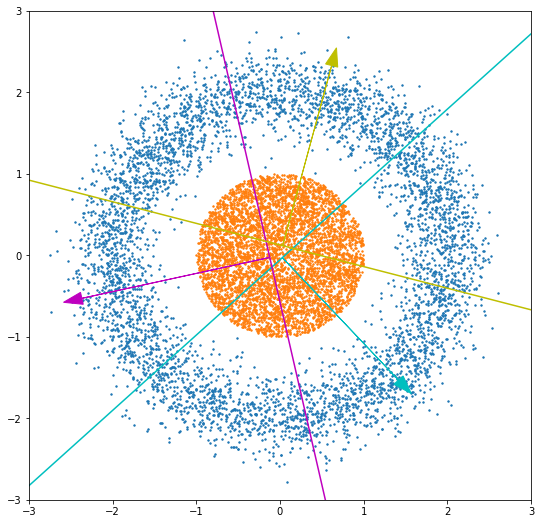

In [10]:
#Visualisation des premières couches.
plt_1 = plt.figure(figsize=(9, 9))
plt.scatter(X_train[np.where(Y_train ==0)][:,0],X_train[np.where(Y_train ==0)][:,1],s=2)
plt.scatter(X_train[np.where(Y_train ==1)][:,0],X_train[np.where(Y_train ==1)][:,1],s=2)
#ligne 1
X = [-3,3]
y1 = [(-w0[0][0]*x-b0[0])/w0[1][0] for x in X]
xi = (b0[0]/w0[1][0])/((-w0[0][0])/w0[1][0] - (w0[1][0])/w0[0][0])
yi = (w0[1][0])/w0[0][0] * xi
plt.arrow(xi, yi, w0[0][0], w0[1][0],head_width=0.15, color = 'c')
#ligne 2
y2 = [(-w0[0][1]*x-b0[1])/w0[1][1] for x in X]
xi = (b0[1]/w0[1][1])/((-w0[0][1])/w0[1][1] - (w0[1][1])/w0[0][1])
yi = (w0[1][1])/w0[0][1] * xi
plt.arrow(xi, yi, w0[0][1], w0[1][1],head_width=0.15, color = 'm')

#ligne 3
y3 = [(-w0[0][2]*x-b0[2])/w0[1][2] for x in X]
xi = (b0[2]/w0[1][2])/((-w0[0][2])/w0[1][2] - (w0[1][2])/w0[0][2])
yi = (w0[1][2])/w0[0][2] * xi
plt.arrow(xi, yi, w0[0][2], w0[1][2],head_width=0.15, color = 'y')

plt.plot(X,y1,'c',X,y2,'m',X,y3,'y')

plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.show()
plt.close()

Interprétation des paramètres de la première couche : <br>
La première couche donne trois évaluations des coordonnées du point d'entrée.
Plus une évaluation est grande, plus le point est éloigné du centre/ de la classe 0 dans la direction du vencteur correspondant à l'évaluation. (Avec la fonction activation $f(x) = max(0,x)$ on ne considère que des scores positifs. <br> 
La 2ème couche ne sert qu'a combiner les scores précédents et inverser leur signe : i.e. plus un point aura de grands score à la couche 1, plus ils seront petit (borné par 0) à la couche 2. <br>
L'output est décidé en faisant la somme des des scores de la couche 2 et en les ajustant.
<br><br>
En réalité on voit que l'on a besoin que d'une seule couche cachée, la deuxième ne servant pas.

## Causalité

Le graphe causal correspondant au réseau de neurone précédent construit ci-dessous. <br><br>
Les variable exogènes sont donc l'entrée du réseau de neurone. <br><br>
Les variables endogènes correspondent aux différents scores évoqués précédemment :<br>
Les ```v0_```correspondent aux 3 scores de la première couche cachée.<br>
Les ```v1_```correspondent aux 2 scores de la deuxièmes couche cachée.<br>
La variable ```output```correspond à la sortie/prédiction du réseau de neurone.

In [13]:
U = {'u0': [-3+i*0.06 for i in range(101)],\
    'u1':[-3+i*0.06 for i in range(101)]} 
V = {'v00' : [i for i in range(6)],
     'v01' : [i for i in range(7)],\
     'v02' : [i for i in range(7)],\
     
     'v10' : [i for i in range(4)],\
     'v11' : [i for i in range(4)],\
     
     'output' : [0,1]}

w0 = MLP.coefs_[0]
w1 = MLP.coefs_[1]
w2 = MLP.coefs_[2]
b0 = MLP.intercepts_[0]
b1 = MLP.intercepts_[1]
b2 = MLP.intercepts_[2]

def compute_v00(param):
    u0 = param['u0']
    u1 = param['u1']
    return int(max(0,(np.array([u0,u1]) @ w0[:,0])+b0[0]))

def compute_v01(param):
    u0 = param['u0']
    u1 = param['u1']
    return int(max(0,(np.array([u0,u1]) @ w0[:,1])+b0[1]))

def compute_v02(param):
    u0 = param['u0']
    u1 = param['u1']
    return int(max(0,(np.array([u0,u1]) @ w0[:,2])+b0[2]))

def compute_v10(param):
    v00 = param['v00']
    v01 = param['v01']
    v02 = param['v02']
    return int(max(0,(np.array([v00,v01,v02]) @ w1[:,0])+b1[0]))
               
def compute_v11(param):
    v00 = param['v00']
    v01 = param['v01']
    v02 = param['v02']
    return int(max(0,(np.array([v00,v01,v02]) @ w1[:,1])+b1[1]))
               
def compute_output(param):
    v10 = param['v10']
    v11 = param['v11']
    res = np.array([v10,v11]) @ w2
    return int(sigmoid(res+b2[0])>0.5)

P = {'v00' : (['u0','u1'],compute_v00),\
     'v01' : (['u0','u1'],compute_v01),\
     'v02' : (['u0','u1'],compute_v02),\
     
     'v10' : (['v00','v01','v02'],compute_v10),\
     'v11' : (['v00','v01','v02'],compute_v11),\
     
     'output' : (['v10','v11'],compute_output)
    }
C = {'u0' : ['v00','v01','v02'],\
     'u1' : ['v00','v01','v02'],\
     'v00' : ['v10','v11'],\
     'v01' : ['v10','v11'],\
     'v02' : ['v10','v11'],\
     'v10' : ['output'],\
     'v11' : ['output'],\
    }

Graph = CausalGraph(P,C)
Mod = Model(U,V,Graph)


On peut vérifier que le graphe causal réalise de bonnes prédiction, comme le réseau de neurone.

In [14]:
#check
for s in np.random.randint(100000,size = 10):
    X,Y = generedata(N = 1000,seed = s)
    Y_pred = []
    for x in X:
        u = {'u0': x[0],\
             'u1': x[1]}
        v = dict()
        Sit = Situation(Mod,u,v)
        Y_pred.append(value('output',Sit))
    Y_pred = np.array(Y_pred)
    assert scoring(Y_pred,Y) > 99

### Exemple positif

In [15]:
X,Y = generedata(N = 1,seed = 5)
u = {'u0': X[0][0],\
    'u1': X[0][1]}
v = dict()
Sit = Situation(Mod,u,v)
Sit.set_val_v()
v

{'v00': 1, 'v01': 0, 'v02': 0, 'v10': 2, 'v11': 2, 'output': 1}

In [16]:
fact = {'output':1}
l = actual_cause_generator(fact,Sit)
for c in l:
    print(c)
    assert test_AC1(c,fact,Sit)
    assert test_AC2(c,fact,Sit)
    assert test_AC3(c,fact,Sit)

{'v02': 0}
{'v01': 0}
{'v00': 1}
{'v10': 2, 'v11': 2}


L'exemple a été classifier positivement, comme vu précédemment, il obtient des scores très faibles pour la première couches, ce qui lui donne un score de 2/3 sur la couche suivante. Enfin, cela le classe psitivement. <br>
En analysant couche par couche, on remarque que pour être classer positivement, pour la première couche il faut avoir 3 scores faibles. Et pour la seconde couche il faut avoir au moins un grand score sur les 2 (conjonction de cause). 

In [17]:
fact = {'v10':2}
foil = {'v10':0}
counterfactual_cause_generator(fact,foil,Sit)

[({'v02': 0}, {'v02': 1}),
 ({'v02': 0}, {'v02': 2}),
 ({'v02': 0}, {'v02': 3}),
 ({'v02': 0}, {'v02': 4}),
 ({'v02': 0}, {'v02': 5}),
 ({'v02': 0}, {'v02': 6}),
 ({'v01': 0}, {'v01': 1}),
 ({'v01': 0}, {'v01': 2}),
 ({'v01': 0}, {'v01': 3}),
 ({'v01': 0}, {'v01': 4}),
 ({'v01': 0}, {'v01': 5}),
 ({'v01': 0}, {'v01': 6}),
 ({'v00': 1}, {'v00': 0}),
 ({'v00': 1}, {'v00': 2}),
 ({'v00': 1}, {'v00': 3}),
 ({'v00': 1}, {'v00': 4}),
 ({'v00': 1}, {'v00': 5})]

In [19]:
fact = {'v10':2}
foil = {'v10':1}
counterfactual_cause_generator(fact,foil,Sit)

[({'v02': 0}, {'v02': 1}),
 ({'v02': 0}, {'v02': 2}),
 ({'v01': 0}, {'v01': 1}),
 ({'v01': 0}, {'v01': 2}),
 ({'v00': 1}, {'v00': 0})]

Pour avoir un score de 1 sur cette variable de la 2ème couche, il aurait fallu avoir des scores plus élevés à la couche précédente. Mais pas trop non plus, sinon on aurait un score de 0. <br>
Encore une fois la cause proposée correspond bien à ce qu'on avait déduit graphiquement.

In [20]:
fact = {'v10' : 2}
foil = {'v10' : 3}
counterfactual_cause_generator(fact,foil,Sit)

[({'v00': 1}, {'v00': 0})]

Pour avoir un score de 3 (le maximum), il aurait fallu avoir 0 sur tous les scores de la première couche.

In [21]:
fact = {'output' : 1}
foil = {'v10' : 3}
counterfactual_cause_generator(fact,foil,Sit)

[({'v00': 1}, {'v00': 0}),
 ({'v11': 2}, {'v11': 0}),
 ({'v11': 2}, {'v11': 1}),
 ({'v11': 2}, {'v11': 3})]

In [16]:
fact = {'output' : 1}
foil = {'v10':3}
counterfactual_cause_generator(fact,foil,Sit)

[({'v00': 1}, {'v00': 0}),
 ({'v11': 2}, {'v11': 0}),
 ({'v11': 2}, {'v11': 1}),
 ({'v11': 2}, {'v11': 3})]

Ici, on a un résultat intéressant, montrant un peu les limites du modèle de causalité de Miller : on trouve qu'une variable de la deuxième couche est cause d'une autre variable de la deuxième couche. Alors qu'il n'y a pas de vrai lien causal entre les 2, simplement une très forte corrélation (les 2 varialbes ont des valeurs extrêmement proches et causées par les mêmes raisons). 

In [22]:
fact = {'v10' : 2}
foil = {'output' : 0}
counterfactual_cause_generator(fact,foil,Sit)

[({'v02': 0}, {'v02': 1}),
 ({'v02': 0}, {'v02': 2}),
 ({'v02': 0}, {'v02': 3}),
 ({'v02': 0}, {'v02': 4}),
 ({'v02': 0}, {'v02': 5}),
 ({'v02': 0}, {'v02': 6}),
 ({'v01': 0}, {'v01': 1}),
 ({'v01': 0}, {'v01': 2}),
 ({'v01': 0}, {'v01': 3}),
 ({'v01': 0}, {'v01': 4}),
 ({'v01': 0}, {'v01': 5}),
 ({'v01': 0}, {'v01': 6}),
 ({'v00': 1}, {'v00': 0}),
 ({'v00': 1}, {'v00': 2}),
 ({'v00': 1}, {'v00': 3}),
 ({'v00': 1}, {'v00': 4}),
 ({'v00': 1}, {'v00': 5})]

Avec cette ces instructions, on restreint la liste des causes de ```(outpout = 1),(outpout = 0)``` aux causes de ```(v10 : 2)```.

### Exemple négatif

On prends un exemple proche du vecteur correspondant au 2ème score de la première couche.

In [23]:
u = {'u0': -2.5,\
    'u1': -1.5}
v = dict()
Sit = Situation(Mod,u,v)
Sit.set_val_v()
v

{'v00': 0, 'v01': 6, 'v02': 0, 'v10': 0, 'v11': 0, 'output': 0}

In [24]:
fact = {'output':0}
l = actual_cause_generator(fact,Sit)
for c in l:
    print(c)
    assert test_AC1(c,fact,Sit)
    assert test_AC2(c,fact,Sit)
    assert test_AC3(c,fact,Sit)

{'v11': 0}
{'v10': 0}
{'v01': 6}


On observe que le fait que l'exemple soit classifié négativement repose sur 3 causes : que les scores de la deuxième couche sont nuls et qu'un score sur la première couche est très élevé.

In [25]:
fact = {'v10':0}
foil = {'v10':3}
counterfactual_cause_generator(fact,foil,Sit)

[({'v01': 6}, {'v01': 0})]

On observe que pour qu'une variable de la deuxième couche ait une valeur élevée il faut que toutes les variables de la première couche ait une valeur nulle.

Toutes ces observations confirment aussi bien l'analyse graphique que la robustesse du modèle.